In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('train_set.csv')

In [6]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166835 entries, 0 to 1166834
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   user_id         1166835 non-null  int64 
 1   checkin         1166835 non-null  object
 2   checkout        1166835 non-null  object
 3   city_id         1166835 non-null  int64 
 4   device_class    1166835 non-null  object
 5   affiliate_id    1166835 non-null  int64 
 6   booker_country  1166835 non-null  object
 7   hotel_country   1166835 non-null  object
 8   utrip_id        1166835 non-null  object
dtypes: int64(3), object(6)
memory usage: 80.1+ MB


,user_id,city_id,affiliate_id
count,1.166835e+06,1.166835e+06,1.166835e+06
mean,3.129535e+06,3.347059e+04,5.719503e+03
std,1.808045e+06,1.958255e+04,3.964435e+03
min,2.900000e+01,2.000000e+00,5.000000e+00
25%,1.562185e+06,1.701300e+04,9.340000e+02
50%,3.126222e+06,3.228200e+04,6.309000e+03
75%,4.701432e+06,5.112800e+04,9.924000e+03
max,6.258087e+06,6.756500e+04,1.069700e+04


In [7]:
df['checkin'] = pd.to_datetime(df['checkin'])
df['checkout'] = pd.to_datetime(df['checkout'])

In [8]:
# New feature: trip_duration 
df['trip_duration'] = (df['checkout'] - df['checkin']).dt.days

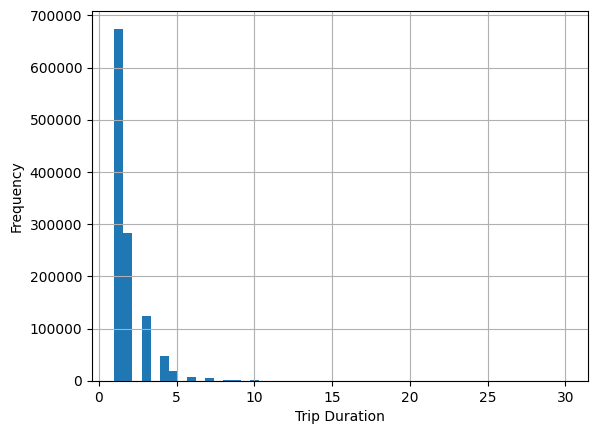

In [9]:
# Visualize the distribution of trip_duration
df['trip_duration'].hist(bins=50)
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.show()

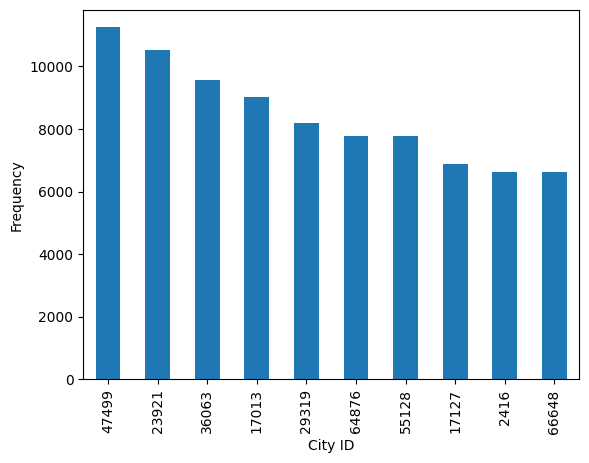

In [10]:
# Analyze frequency of each city_id
df['city_id'].value_counts().head(10).plot(kind='bar')
plt.xlabel('City ID')
plt.ylabel('Frequency')
plt.show()

In [11]:
pd.crosstab(df['booker_country'], df['city_id'])
pd.crosstab(df['device_class'], df['city_id'])

city_id,2,4,5,6,7,8,11,12,13,14,...,67552,67553,67556,67557,67558,67559,67560,67562,67563,67565
device_class,,,,,,,,,,,,,,,,,,,,,
desktop,0,1,13,7,21,2,3,5,1,1,...,4,1,2,1,0,1,57,1,3,5
mobile,1,0,4,1,7,0,3,1,0,0,...,3,0,0,0,3,0,49,0,3,0
tablet,0,0,2,0,4,0,1,1,1,0,...,1,0,0,0,0,0,2,0,0,0


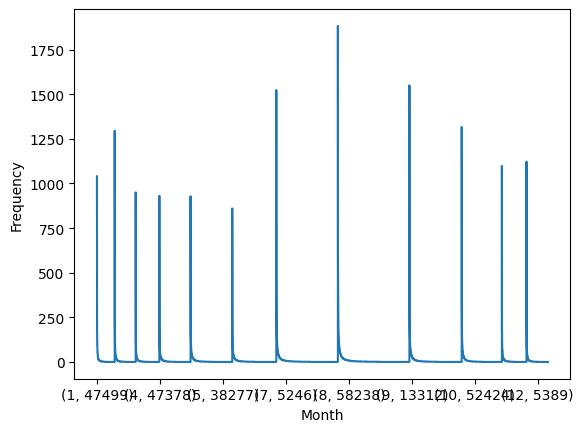

In [12]:
# Check seasonality
df['checkin_month'] = df['checkin'].dt.month
df.groupby('checkin_month')['city_id'].value_counts().plot(kind='line')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

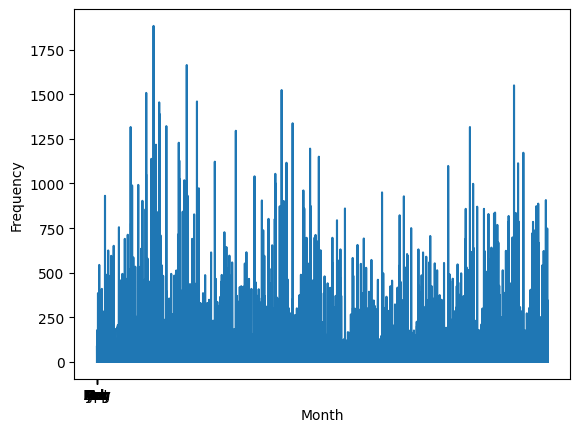

In [13]:
import calendar

# Convert numeric month to month names
df['checkin_month'] = df['checkin'].dt.month.apply(lambda x: calendar.month_abbr[x])

# Plot
df.groupby('checkin_month')['city_id'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(12), calendar.month_abbr[1:13])  # Set x-ticks labels to month names
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['city_id'] = le.fit_transform(df['city_id'])
df['user_id'] = le.fit_transform(df['user_id'])

In [15]:
sequences = df.sort_values(['checkin']).groupby('utrip_id')['city_id'].apply(list)
X = [seq[:-1] for seq in sequences]
y = [seq[-1] for seq in sequences]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

2024-05-15 21:02:14.088174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 21:02:19.614562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2024-05-15 21:02:37.129363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 21:02:37.642169: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/ajay/Documents/projects/RecSys-local/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first laye